### Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv). = 'test.csv'

In [1]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
DATASET_PATH  = 'train.csv'
DATASET_VALID = 'test.csv'

### Описание датасета:
Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры


#### Загружаем и анализируем данные

In [3]:
df = pd.read_csv(DATASET_PATH)
df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.204377
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,95380.220993


#### Функция преобразование данных

In [4]:
def Convertion_data(df):
    df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
    df.loc[df['Ecology_2'] == 'B', 'Ecology_2'] = 1
    df.loc[df['Ecology_2'] == 'A', 'Ecology_2'] = 0
    df.loc[df['Ecology_3'] == 'B', 'Ecology_3'] = 1
    df.loc[df['Ecology_3'] == 'A', 'Ecology_3'] = 0
    df.loc[df['Shops_2'] == 'B', 'Shops_2'] = 1
    df.loc[df['Shops_2'] == 'A', 'Shops_2'] = 0 
    

 #### Функция вывода значение точности и ошибки

In [5]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10)) 
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

##### Преобразовываем тестовые данные

In [6]:
Convertion_data(df)

##### Анализ целевой переменной(отклонений не замечено)

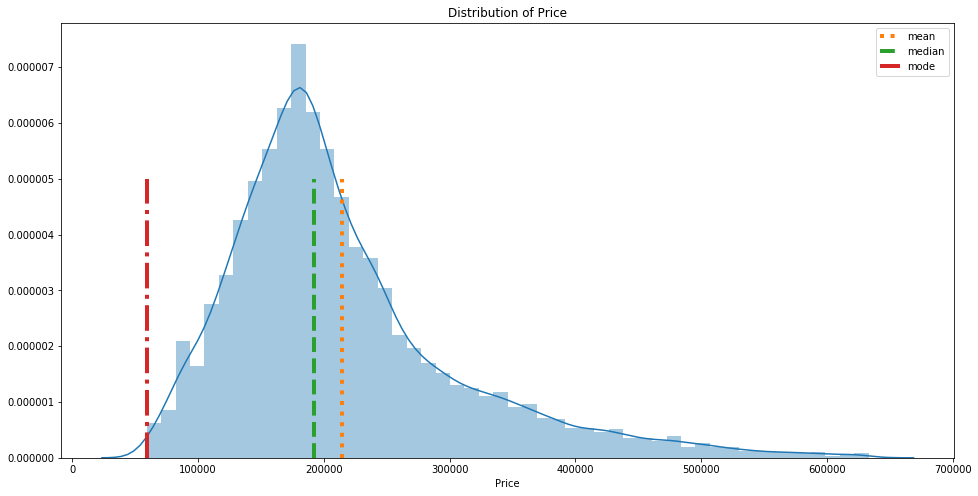

In [7]:
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]

plt.figure(figsize = (16, 8))

sns.distplot(df['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean]*100 , y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median]*100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode]*100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

In [8]:
# Выводим кореляционную матрицу для анализа

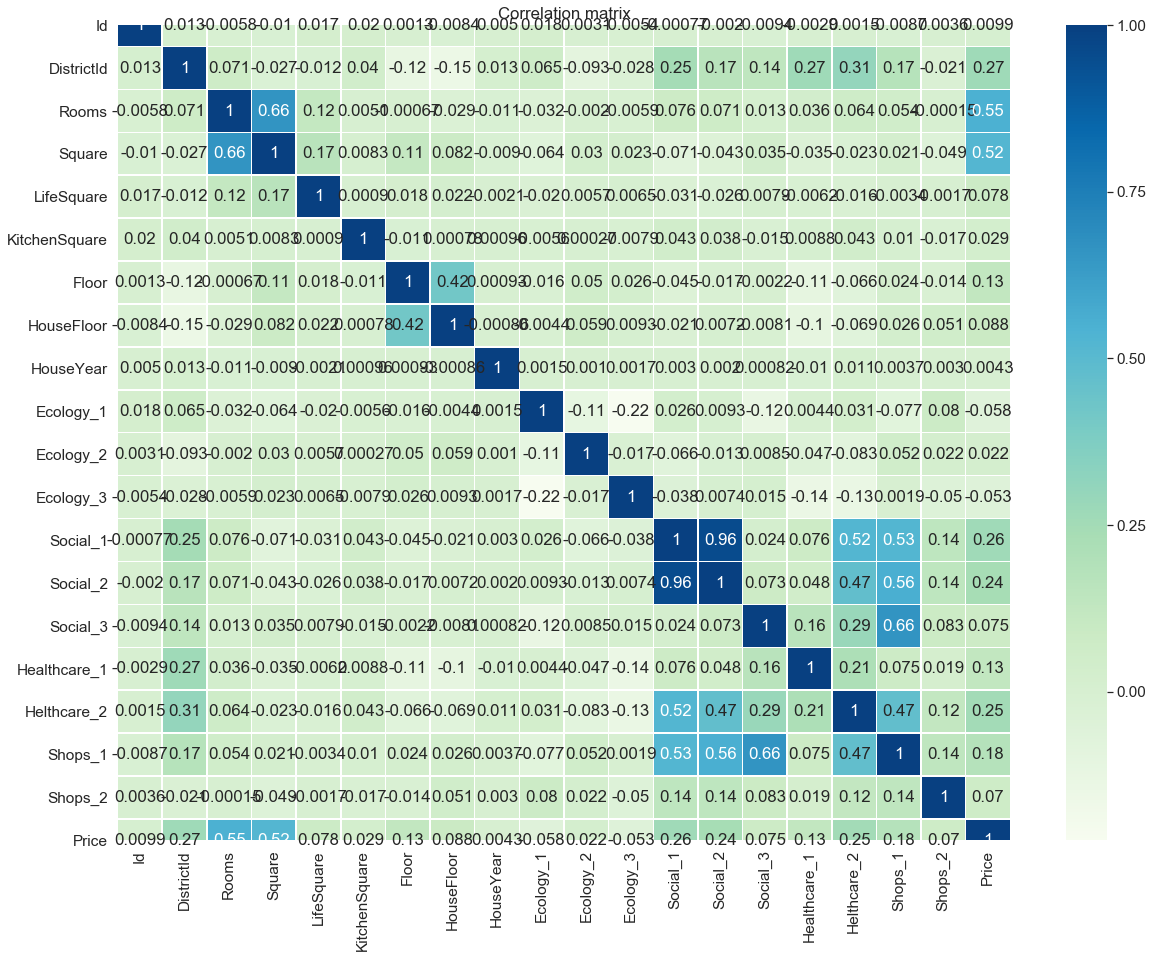

In [9]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [10]:
# Видим, что параметр "Social_1" сильно коррелирует с "Social_2" (0,96). Принято решенеие убрать "Social_2".  

In [11]:
feature_names = [
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
#  'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

target_name = ['Price']

In [12]:
X = df[feature_names]
y = df[target_name]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=21)

In [14]:
# При использовании всех изученных моделей, самым эффективным оказался "GradientBoostingRegressor".
# С помощью GridSearchCV были найдены оптимальные параметры.

In [15]:
Best_model = GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=21)
Best_model.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.888
MAE:	20140.321
MSE:	957904292.67


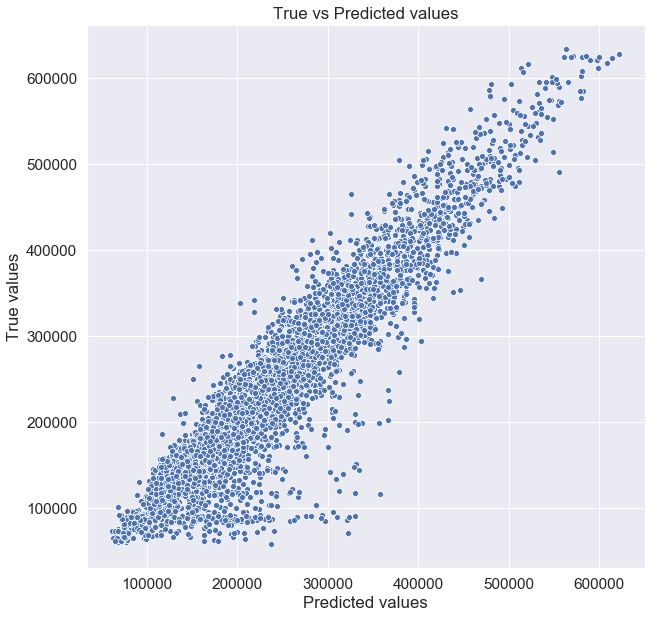

In [16]:
y_train_preds = Best_model.predict(X_train)
evaluate_preds(y_train['Price'], y_train_preds)

R2:	0.758
MAE:	27006.097
MSE:	2221906929.847


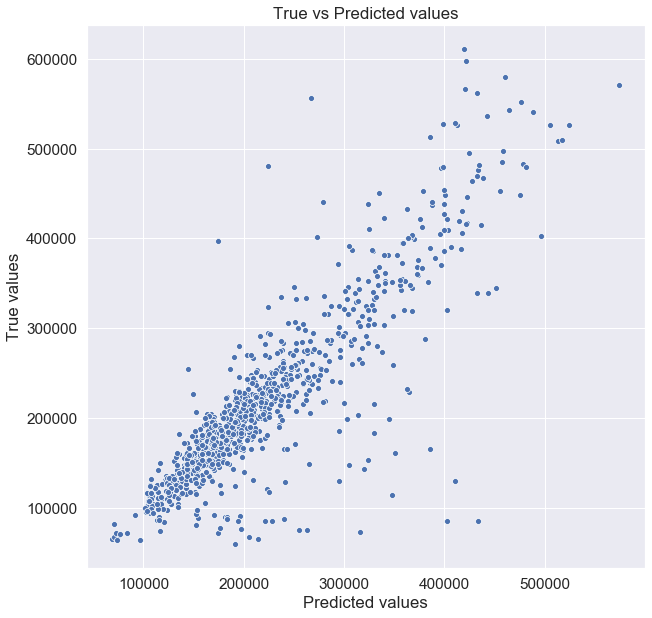

In [17]:
y_test_preds = Best_model.predict(X_test)
evaluate_preds(y_test['Price'], y_test_preds)

In [18]:
# Считываем тестовые данные для предсказания

In [23]:
df_t = pd.read_csv(DATASET_VALID)

In [24]:
# Обработка тестовой выборки

In [25]:
Convertion_data(df_t)

In [26]:
# Предсказание

In [27]:
df_t["Price"] = Best_model.predict(df_t[feature_names])

In [28]:
# Сохранение результата

In [29]:
df_t[['Id','Price']].to_csv('YuriyChkanov_predictions',index = False)